#  __Quantum factorization of 143 using 4 Qubits__

VQF is a hybrid of both quantum and classical methods which transforms the factorization problem into an optimization problem. In the below example the integer 143 is factorized into 11 and 13 using only 4 qubits. 

## Essential Imports

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
simulator = Aer.get_backend('qasm_simulator')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from sympy import symbols, linsolve
from qiskit.algorithms.optimizers import COBYLA
import cmath, math
import pandas as pd

## Setting up the optimization problem

The initial process involves converting the integer into binary and writing the unknown digits of factors as variables p and q.
The factors can be written as (1 p1 p2 1) and (1 q1 q2 1). These can be used to plot a binary multiplication table as shown below.

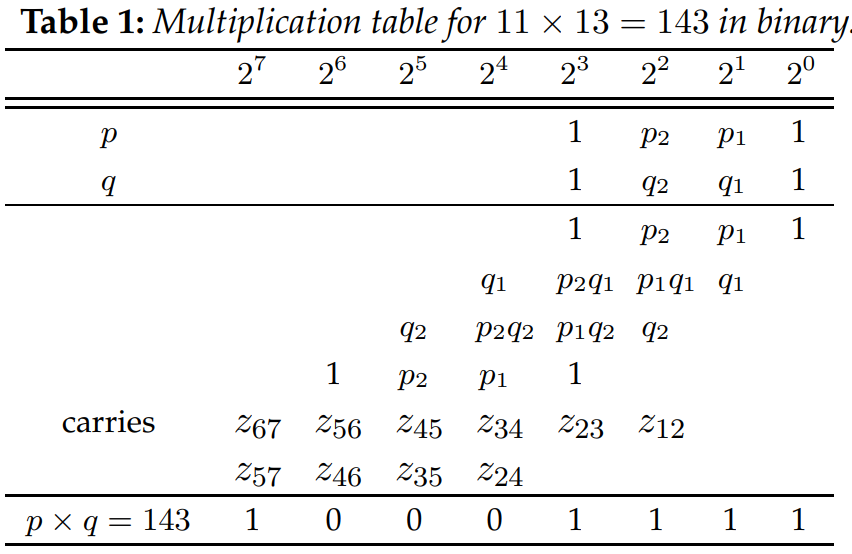

From the above table we get a set of equations which are:

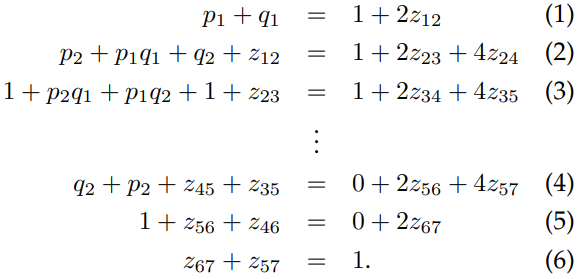

The above equations can be simplified using the rules of binary addition and we get:

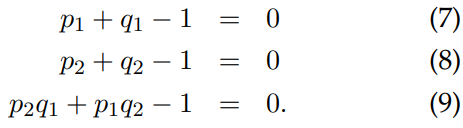

Equations 7,8 and 9 are squared and added to get a function which is to be redused to get the values p1, p2, q1 and q2.

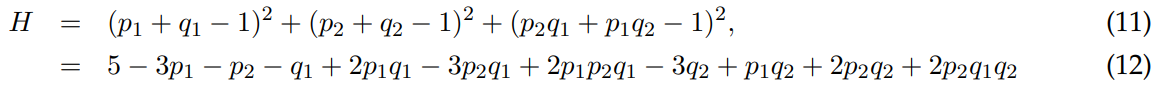

We can define the function in python as:

In [3]:
def H_function(p1,p2,q1,q2):
    y = (5-(3*p1)-p2-q1+(2*p1*q1)-(3*p2*q1)+(2*p1*p2*q1)-
         (3*q2)+(p1*q2)+(2*p2*q2)+(2*p2*q1*q2))
    return y

Each variable in the above function can take the values 0 or 1. Since there are 4 variables there would be a total of 16 possible combinations. Giving those inputs to the function yields a list of values that are stored in the list _dig_H_.

In [4]:
dig_H = []
for i_ in range(2):
    for j_ in range(2):
        for k_ in range(2):
            for l_ in range(2):
                dig_H.append(H_function(i_,j_,k_,l_))

Considering the list _dig_H_ as the diagonal elements we can define a matrix that acts as the Hamiltonian of the VQF method.

In [5]:
H = np.zeros((16,16)).astype('int')
for i_ in range(16):
    H[i_][i_] = dig_H[i_]
H

array([[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]])

### Decomposing the matrix into sum of tensor products of pauli matrices:

"_Expectation value of a Hamiltonian can be written as the linear combination of expectation value of tensor product of pauli matrices_". This principle can be employed to get an equation for the expectation value of the matrix _H_. For that first we have to decompose the above matrix. Since the matrix H only involve diagonal elements we have to consider only the combinations of I and Z matrix.

In [6]:
I = np.array([[1, 0],[0, 1]])
Z = np.array([[1, 0],[0, -1]])
pauli = [I,Z]
pauli_str = ['i','z']

A 16*16 Matrix in the pauli matrix basis can be written as:

$$
H =\sum_{i,j,k,l}h_{ijkl}\cdot \frac{1}{4}\sigma_i\otimes\sigma_j\otimes\sigma_k\otimes\sigma_l,
$$

where the coefficient $h_{ijkl}$ can be written as:

$$
h_{ijkl} = \frac{1}{4}\text{Tr}\big((\sigma_i\otimes\sigma_j\otimes\sigma_k\otimes\sigma_l)^\dagger \cdot H\big) = \frac{1}{4}\text{Tr}\big((\sigma_i\otimes\sigma_j\otimes\sigma_k\otimes\sigma_l) \cdot H\big) 
$$

In [7]:
express = "H = "
H_test = np.zeros((16,16))
coeff = []
basis = []
basis_arr = np.zeros((2,2,2,2,16,16))
for k_ in range(2):
    for l_ in range(2):
        for m_ in range(2):
            for n_ in range(2):
                basis.append(np.kron(np.kron(pauli[k_],pauli[l_]),np.kron(pauli[m_],pauli[n_])))
                basis_arr[k_][l_][m_][n_] = np.kron(np.kron(pauli[k_],pauli[l_]),np.kron(pauli[m_],pauli[n_]))
                if (1/16)*np.trace(np.kron(np.kron(pauli[k_],pauli[l_]),np.kron(pauli[m_],pauli[n_]))*H) != 0:
                    coeff.append((1/16)*np.trace(np.kron(np.kron(pauli[k_],pauli[l_]),np.kron(pauli[m_],pauli[n_]))*H))
                    express += f'{(1/16)*np.trace(np.kron(np.kron(pauli[k_],pauli[l_]),np.kron(pauli[m_],pauli[n_]))*H)}*' + f'{pauli_str[k_]+pauli_str[l_]+pauli_str[m_]+pauli_str[n_]} +'
                H_test += ((1/16)*np.trace(np.kron(np.kron(pauli[k_],pauli[l_]),np.kron(pauli[m_],pauli[n_]))*H))*(np.kron(np.kron(pauli[k_],pauli[l_]),np.kron(pauli[m_],pauli[n_])))
express = express[:-2]
express

'H = 2.0*iiii +0.5*iiiz +0.25*iizi +0.25*iizz +0.25*izii +0.75*iziz +-0.25*izzi +-0.25*izzz +0.5*ziii +0.25*ziiz +0.75*zizi +0.25*zzii +-0.25*zzzi'

## Variational Quantum Circuits

To find the expectation value of individual elements in the pauli matrix basis we have to use variational quantum circuits that takes in certain parameters that act as the ansatz. These ansatz manipulate the qubits which can be visualized as rotations. Variying these parameters using an optimization algorithm can be used to find a suitable expectation value.

For this particular example we have tried a set of 10 variational quantum circuits. These circuits also involve depths that repeats the circuit several times for better results.

### Circuit 00

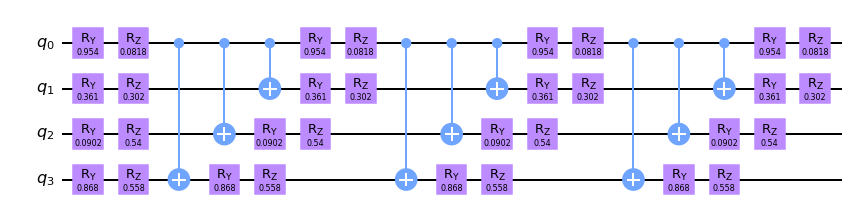

In [8]:
def var_form_ryrz_00(params, depth):
    var_circ = QuantumCircuit(4)
    var_circ.ry(params[0], 0)
    var_circ.rz(params[1], 0)
    var_circ.ry(params[2], 1)
    var_circ.rz(params[3], 1)
    var_circ.ry(params[4], 2)
    var_circ.rz(params[5], 2)
    var_circ.ry(params[6], 3)
    var_circ.rz(params[7], 3)
           
    for jj in range(depth):
        var_circ.cx(0, 3)
        var_circ.cx(0, 2)
        var_circ.cx(0, 1)
        var_circ.ry(params[0], 0)
        var_circ.rz(params[1], 0)
        var_circ.ry(params[2], 1)
        var_circ.rz(params[3], 1)
        var_circ.ry(params[4], 2)
        var_circ.rz(params[5], 2)
        var_circ.ry(params[6], 3)
        var_circ.rz(params[7], 3)
            
    return var_circ 

params = np.random.rand(8)
var_form_ryrz_00(params, 3).draw()

### Circuit 01

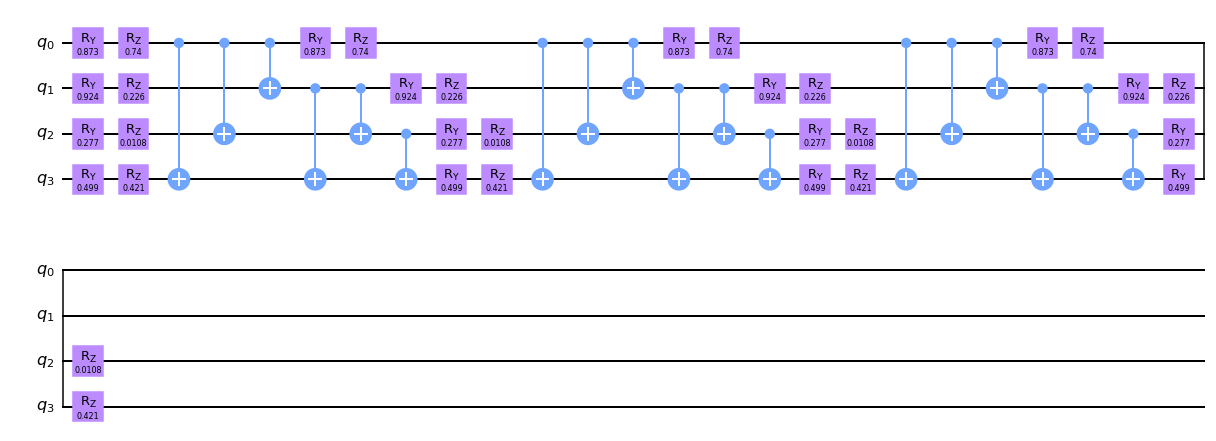

In [9]:
def var_form_ryrz_01(params, depth):
    var_circ = QuantumCircuit(4)
    var_circ.ry(params[0], 0)
    var_circ.rz(params[1], 0)
    var_circ.ry(params[2], 1)
    var_circ.rz(params[3], 1)
    var_circ.ry(params[4], 2)
    var_circ.rz(params[5], 2)
    var_circ.ry(params[6], 3)
    var_circ.rz(params[7], 3)
           
    for jj in range(depth):
        
        var_circ.cx(0, 3)
        var_circ.cx(0, 2)
        var_circ.cx(0, 1)
        var_circ.cx(1, 3)
        var_circ.cx(1, 2)
        var_circ.cx(2, 3)
        
        var_circ.ry(params[0], 0)
        var_circ.rz(params[1], 0)
        var_circ.ry(params[2], 1)
        var_circ.rz(params[3], 1)
        var_circ.ry(params[4], 2)
        var_circ.rz(params[5], 2)
        var_circ.ry(params[6], 3)
        var_circ.rz(params[7], 3)
            
    return var_circ  

params = np.random.rand(8)
var_form_ryrz_01(params, 3).draw()

### Circuit 02

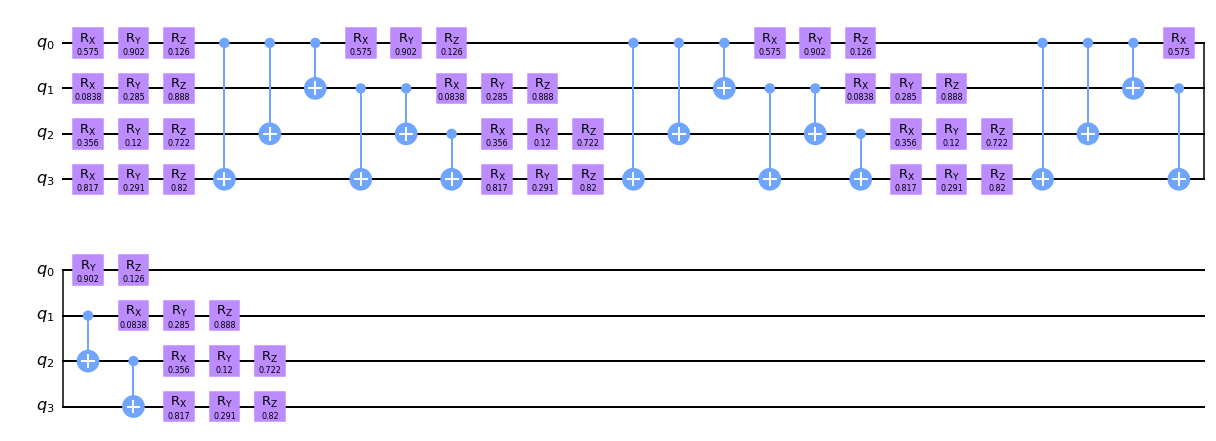

In [10]:
def var_form_ryrz_02(params, depth):
    var_circ = QuantumCircuit(4)
    var_circ.rx(params[0], 0)
    var_circ.ry(params[1], 0)
    var_circ.rz(params[2], 0)
    var_circ.rx(params[3], 1)
    var_circ.ry(params[4], 1)
    var_circ.rz(params[5], 1)
    var_circ.rx(params[6], 2)
    var_circ.ry(params[7], 2)
    var_circ.rz(params[8], 2)
    var_circ.rx(params[9], 3)
    var_circ.ry(params[10], 3)
    var_circ.rz(params[11], 3)
           
    for jj in range(depth):
        var_circ.cx(0, 3)
        var_circ.cx(0, 2)
        var_circ.cx(0, 1)
        var_circ.cx(1, 3)
        var_circ.cx(1, 2)
        var_circ.cx(2, 3)
        
        var_circ.rx(params[0], 0)
        var_circ.ry(params[1], 0)
        var_circ.rz(params[2], 0)
        var_circ.rx(params[3], 1)
        var_circ.ry(params[4], 1)
        var_circ.rz(params[5], 1)
        var_circ.rx(params[6], 2)
        var_circ.ry(params[7], 2)
        var_circ.rz(params[8], 2)
        var_circ.rx(params[9], 3)
        var_circ.ry(params[10], 3)
        var_circ.rz(params[11], 3)
            
    return var_circ

params = np.random.rand(12)
var_form_ryrz_02(params, 3).draw()

### Circuit 03

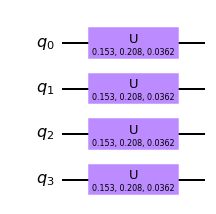

In [11]:
def var_form_ryrz_03(params, depth):
    
    var_circ = QuantumCircuit(4)
    var_circ.u(params[0],params[1],params[2],0)
    var_circ.u(params[0],params[1],params[2],1)
    var_circ.u(params[0],params[1],params[2],2)
    var_circ.u(params[0],params[1],params[2],3)
            
    return var_circ 

params = np.random.rand(3)
var_form_ryrz_03(params, 0).draw()

### Circuit 04

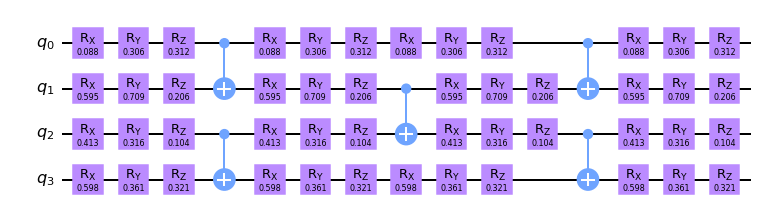

In [12]:
def var_form_ryrz_04(params, depth):
    var_circ = QuantumCircuit(4)
    var_circ.rx(params[0], 0)
    var_circ.ry(params[1], 0)
    var_circ.rz(params[2], 0)
    var_circ.rx(params[3], 1)
    var_circ.ry(params[4], 1)
    var_circ.rz(params[5], 1)
    var_circ.rx(params[6], 2)
    var_circ.ry(params[7], 2)
    var_circ.rz(params[8], 2)
    var_circ.rx(params[9], 3)
    var_circ.ry(params[10], 3)
    var_circ.rz(params[11], 3)
           
    for jj in range(depth):
        if (jj+1)%2 != 0 :
            var_circ.cx(0, 1)
            var_circ.cx(2, 3)
        else:
            var_circ.cx(1, 2)
        
        var_circ.rx(params[0], 0)
        var_circ.ry(params[1], 0)
        var_circ.rz(params[2], 0)
        var_circ.rx(params[3], 1)
        var_circ.ry(params[4], 1)
        var_circ.rz(params[5], 1)
        var_circ.rx(params[6], 2)
        var_circ.ry(params[7], 2)
        var_circ.rz(params[8], 2)
        var_circ.rx(params[9], 3)
        var_circ.ry(params[10], 3)
        var_circ.rz(params[11], 3)
            
    return var_circ  


params = np.random.rand(12)
var_form_ryrz_04(params, 3).draw()

### Circuit 05

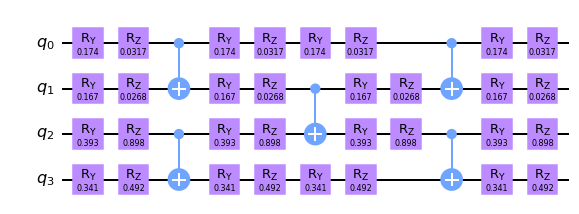

In [13]:
def var_form_ryrz_05(params, depth):
    var_circ = QuantumCircuit(4)
    var_circ.ry(params[0], 0)
    var_circ.rz(params[1], 0)
    var_circ.ry(params[2], 1)
    var_circ.rz(params[3], 1)
    var_circ.ry(params[4], 2)
    var_circ.rz(params[5], 2)
    var_circ.ry(params[6], 3)
    var_circ.rz(params[7], 3)
           
    for jj in range(depth):
        if (jj+1)%2 != 0 :
            var_circ.cx(0, 1)
            var_circ.cx(2, 3)
        else:
            var_circ.cx(1, 2)
        
        var_circ.ry(params[0], 0)
        var_circ.rz(params[1], 0)
        var_circ.ry(params[2], 1)
        var_circ.rz(params[3], 1)
        var_circ.ry(params[4], 2)
        var_circ.rz(params[5], 2)
        var_circ.ry(params[6], 3)
        var_circ.rz(params[7], 3)
            
    return var_circ  

params = np.random.rand(8)
var_form_ryrz_05(params, 3).draw()

### Circuit 06

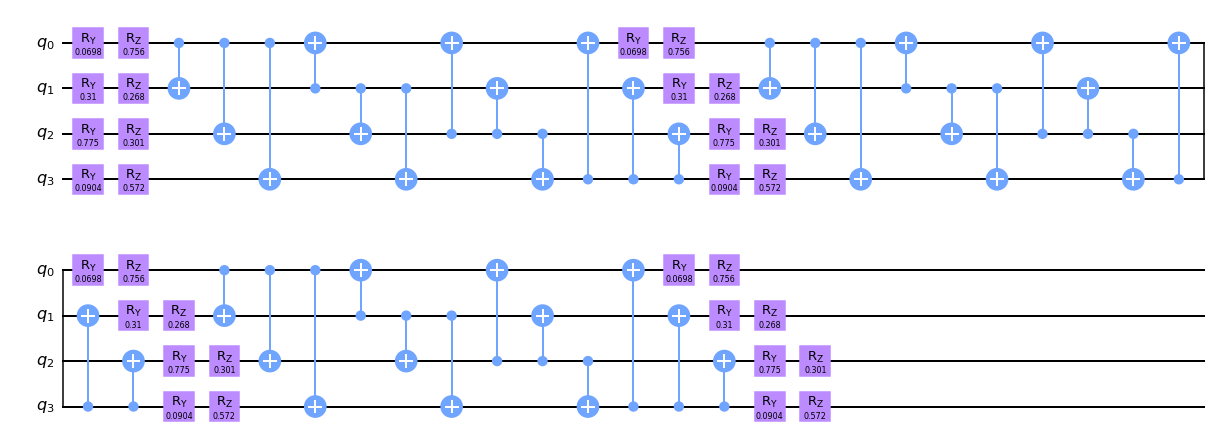

In [14]:
def var_form_ryrz_06(params, depth):
    var_circ = QuantumCircuit(4)
    var_circ.ry(params[0], 0)
    var_circ.rz(params[1], 0)
    var_circ.ry(params[2], 1)
    var_circ.rz(params[3], 1)
    var_circ.ry(params[4], 2)
    var_circ.rz(params[5], 2)
    var_circ.ry(params[6], 3)
    var_circ.rz(params[7], 3)
           
    for jj in range(depth):
        for i in range(4):
            for j in range(4):
                if (i != j) :
                    var_circ.cx(i, j)
        
        var_circ.ry(params[0], 0)
        var_circ.rz(params[1], 0)
        var_circ.ry(params[2], 1)
        var_circ.rz(params[3], 1)
        var_circ.ry(params[4], 2)
        var_circ.rz(params[5], 2)
        var_circ.ry(params[6], 3)
        var_circ.rz(params[7], 3)
            
    return var_circ 

params = np.random.rand(8)
var_form_ryrz_06(params, 3).draw()

### Circuit 07

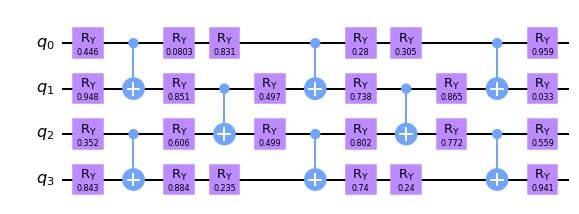

In [15]:
def var_form_ryrz_07(params, depth):
    var_circ = QuantumCircuit(4)
    var_circ.ry(params[0], 0)
    var_circ.ry(params[1], 1)
    var_circ.ry(params[2], 2)
    var_circ.ry(params[3], 3)
    num = 4      
    for jj in range(depth):
        
        if (jj+1)%2 != 0 :
            var_circ.cx(0, 1)
            var_circ.cx(2, 3)
        else:
            var_circ.cx(1, 2)
        
        var_circ.ry(params[num], 0)
        var_circ.ry(params[num+1], 1)
        var_circ.ry(params[num+2], 2)
        var_circ.ry(params[num+3], 3)
        
        num += 4
            
    return var_circ

params = np.random.rand(24)
var_form_ryrz_07(params, 5).draw()

### Circuit 08

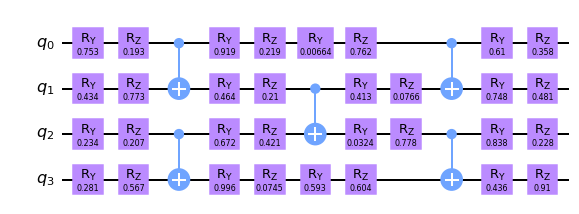

In [16]:
def var_form_ryrz_08(params, depth):
    var_circ = QuantumCircuit(4)
    var_circ.ry(params[0], 0)
    var_circ.rz(params[1], 0)
    var_circ.ry(params[2], 1)
    var_circ.rz(params[3], 1)
    var_circ.ry(params[4], 2)
    var_circ.rz(params[5], 2)
    var_circ.ry(params[6], 3)
    var_circ.rz(params[7], 3)
    num = 8     
    for jj in range(depth):
        
        if (jj+1)%2 != 0 :
            var_circ.cx(0, 1)
            var_circ.cx(2, 3)
        else:
            var_circ.cx(1, 2)
        
        var_circ.ry(params[num+0], 0)
        var_circ.rz(params[num+1], 0)
        var_circ.ry(params[num+2], 1)
        var_circ.rz(params[num+3], 1)
        var_circ.ry(params[num+4], 2)
        var_circ.rz(params[num+5], 2)
        var_circ.ry(params[num+6], 3)
        var_circ.rz(params[num+7], 3)
        
        num += 8
            
    return var_circ

params = np.random.rand(32)
var_form_ryrz_08(params, 3).draw()

### Circuit 09

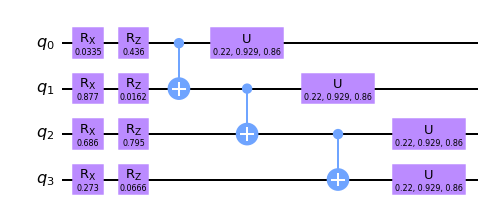

In [17]:
def var_form_ryrz_09(params, depth):
    var_circ = QuantumCircuit(4)
    var_circ.rx(params[0], 0)
    var_circ.rz(params[1], 0)
    var_circ.rx(params[2], 1)
    var_circ.rz(params[3], 1)
    var_circ.rx(params[4], 2)
    var_circ.rz(params[5], 2)
    var_circ.rx(params[6], 3)
    var_circ.rz(params[7], 3)
           
    var_circ.cx(0, 1)
    
    var_circ.cx(1, 2)
    
    var_circ.cx(2, 3)
    
    var_circ.u(params[8], params[9], params[10],0)
    var_circ.u(params[8], params[9], params[10],1)
    var_circ.u(params[8], params[9], params[10],2)
    var_circ.u(params[8], params[9], params[10],3)
            
    return var_circ 

params = np.random.rand(11)
var_form_ryrz_09(params, 0).draw()

## Expectation Function

The expectation value equation can be defined as follows. The function takes in a variational quantum circuit and measures all the expectation values of pauli matrix basis elements. The output is the expectation value of the hamiltonian.

In [18]:
def expectation_function(params, num_shots = 10000):
    var_circ = var_form_ryrz_00(params, 2)
    list_bin = ['0000','0001','0010','0011','0100','0101','0110','0111','1000',
                '1001','1010','1011','1100','1101','1110','1111']
    prob_list = []
    for k_ in range(2):
        for l_ in range(2):
            for m_ in range(2):
                for n_ in range(2):
                    if (1/16)*np.trace(np.kron(np.kron(pauli[k_],pauli[l_]),np.kron(pauli[m_],pauli[n_]))*H) != 0:
                        Basis_meas = var_circ.copy()
                        Basis_meas.measure_all()
                        result = execute(Basis_meas, backend = simulator, shots = num_shots).result()
                        counts = result.get_counts(Basis_meas)
                        for jj in list_bin:
                            if jj not in counts:
                                counts[jj] = 0
                        total_counts = 0
                        for i_ in list(counts.values()):
                            total_counts += i_
                        one = np.ones(16).astype('int')
                        prob = np.inner(np.matmul(one, basis_arr[k_][l_][m_][n_]),list(counts.values()))
                        prob = prob/total_counts
                        prob_list.append(prob)
            
    cost = 0
    for i_ in range(len(prob_list)):
        cost += (prob_list[i_] * coeff[i_] )
    return cost

## Classical Optimization

Our goal is to reduce the value of expectation_function to the minimun. Since the limit of expectation value is from the smallest eigenvalue to the largest eigenvalue, by reducing the expectation_function we get the lowest eigenvalue. This can be done using a classical optimizer. In our example we are using _COBYLA_ which is a gradient free optimizer.

In [ ]:
optimizer = COBYLA(maxiter=200,tol=0.0001)
no_param = 8 #number of anzat parameters for the circuit 
params = np.random.rand(no_param)
ret = optimizer.optimize(num_vars=no_param, objective_function=expectation_function, initial_point=params)
print(ret)
exp = expectation_function(ret[0])
print(exp)

### Optimization dataset for various circuits and depths

For getting the best result we have tried various variational circuits with different values of depths. The dataset shown below shows the same.

In [20]:
dataset = pd.read_csv('exp_datas.csv',index_col=0)

In [21]:
dataset # Each row represents different values of depth (depth = index+1)

,var_form_ryrz_00,var_form_ryrz_01,var_form_ryrz_02,var_form_ryrz_03,var_form_ryrz_04,var_form_ryrz_05,var_form_ryrz_06,var_form_ryrz_07,var_form_ryrz_08
0,0.52855,1.57930,1.73725,0.63785,1.54950,1.04645,2.35155,1.01495,0.70215
1,1.66415,1.49250,1.57640,1.65955,1.29845,0.88940,1.65330,1.29020,1.47625
2,2.42090,1.57155,1.88750,0.77340,1.61670,1.99155,2.18220,1.16705,1.66750
3,2.62705,0.78910,1.83635,1.10540,1.60460,1.11085,2.07910,1.35180,1.59110
4,3.03715,1.01920,2.31965,1.41955,1.55775,1.01505,1.72900,1.68780,1.69135
5,0.81615,1.54355,1.48160,1.59395,1.46715,1.71635,1.45160,2.40590,1.48820
6,0.96925,1.99935,2.01455,1.04350,1.85710,1.37120,3.53355,0.49250,1.39815
7,1.97010,2.00450,1.42530,1.18135,1.26930,1.47220,1.94115,0.95800,1.65920
8,1.95505,1.13185,2.18690,0.76060,1.50955,1.28330,1.77995,2.22960,1.20890


In [22]:
#lowest walue in the dataset
lowest = dataset.min().min()
#The integer lower than that can be the eigenvalue
lowest_eig = math.floor(lowest)

## Determining the binary value corresponding to the lowest eigenvalue

After getting the lowest eigenvalue we can get the binary corresponding to the position of lowest eigenvalue

In [23]:
inti = 0
for i_ in range(2):
    for j_ in range(2):
        for k_ in range(2):
            for l_ in range(2):
                
                if dig_H[inti] == lowest_eig:
                    print(i_,j_,k_,l_)
                
                inti += 1

0 1 1 0
1 0 0 1


We got two positions in which the lowest eigenvalues are present. We can treat them as seperate cases.

### Case 1

p1 = 0, p2 = 1, q1 = 1, q2 = 0

### Case 2

p1 = 1, p2 = 0, q1 = 0, q2 = 1

Both the cases point out that the factors of 143 in binary can be written in binary as 1011 and 1101, which are 11 and 13 respectively.

## Conclusion

We Successfully factorized the number 143 into 11 and 13 using only 4 qubits. This only was possible because the factors differ by only 2 digits in binary form. Similarly any integer whose factors differ by only 2 digits can be factorized using 4 qubits. Examples of such integer are 3599, 11663, and 56153. For the integers with factors differing more than 2 digits we have to use more qubits.